In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [37]:
y_data_raw = []
with open("raw_spectrum.txt", "r") as filin:
    for ligne in filin:
        coords = ligne.split()
        y_data_raw.append(float(coords[1]))

In [38]:
#fichier.read()
#for i in range(
x_data=[]
y_data=[]
n=[]
with open("spectrum.txt", "r") as filin:
    for ligne in filin:
        #print(ligne[:5])
        coords = ligne.split()
        x_data.append(float(coords[0]))
        y_data.append(float(coords[1]))
        n.append(np.sqrt(float(coords[1])))

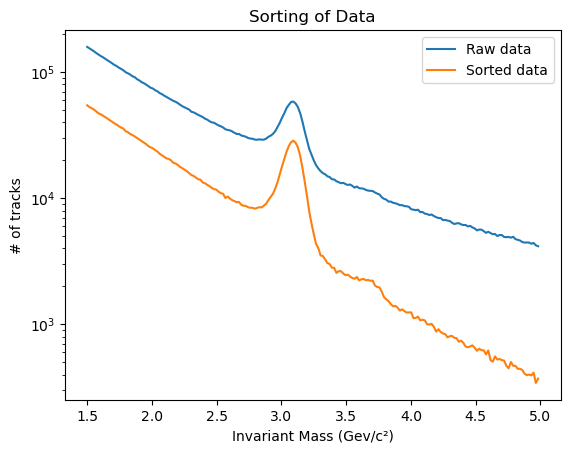

In [39]:
plt.semilogy(x_data, y_data_raw, label = "Raw data")
plt.semilogy(x_data, y_data, label = "Sorted data")
plt.xlabel("Invariant Mass (Gev/c²)")
plt.ylabel("# of tracks")
plt.title("Sorting of Data")
plt.legend()
plt.show()


In [4]:
#CrystalBall2 prend en argument une liste de valeurs de x
def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#CrystalBall2_2 prend en argument une valeur de x
def CrystalBall2_2(i, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
        y = np.exp(-((i-mu)**2)/(2*sigma**2))
    elif ((i-mu)/sigma < alpha):
        y = A*((B- (i -mu)/(sigma))**(-n))
    elif((i-mu)/sigma > alphabis):
        y = C*((D+ (i -mu)/(sigma))**(-nbis))
    return y*N

In [5]:
def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

In [6]:
def CB2withNoise(x, mu_CB2, sigma, N_CB2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    #sigma = 6.10076777e-02
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

def CB2withNoise_2(x, mu_CB2, sigma, N_CB2, mu_CB2_2, N_CB2_2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    #alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    alpha, alphabis, n, nbis =  -0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107 
    #alpha_2, alphabis2, n2, nbis2 = -3.22788197e+00, 2.37452148e+00, 1.82471094e+00, 1.31670260e+00
    alpha_2, alphabis2, n2, nbis2 = 0.8127277269512803, 2.140868246051813, 2.9612888277488696, 2.398926196259195
    #sigma = 6.10076777e-02
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + CrystalBall2(x, mu_CB2_2, 1.05*sigma, alpha_2, alphabis2, n2, nbis2, N_CB2_2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

In [22]:
%time
popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise_2, x_data, y_data, p0=[3.1, 0.07 , 10000., 3.68, 1000. , 6.29517373e-07 , 4.91666545e-01 , 1.19404276e-07 , 10000],
                    sigma=n, absolute_sigma = False,
                    bounds=([3., 0.01 , 0., 3.4, 0. , 0. , 0 , 0 , 0.],[3.2 , 0.1, np.inf, 3.7, np.inf , 1e-5 , 100. , 100. , np.inf]))

print(popt_CB2wNoise,pcov_CB2wNoise)
mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2,mu_DE_fitCB2wNoise,alpha_DE_fitCB2wNoise,beta_fitCB2wNoise,N_DE_fitCB2wNoise = popt_CB2wNoise
#mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2 mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise = popt_CB2wNoise
var_mu, var_sigma, var_N=pcov_CB2wNoise[0,0], pcov_CB2wNoise[1,1], pcov_CB2wNoise[2,2]
sigma_mu = np.sqrt(var_mu)
sigma_sigma = np.sqrt(var_sigma)
sigma_N = np.sqrt(var_N)
print('Variance de la masse du JPsi (mu CB2) :',var_mu)
print('Variance du sigma (sigma CB2) :',var_sigma)
print('Variance de l amplitude CB2 :',var_N)
y_data_fitCB2wNoise=CB2withNoise_2(x_data,mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)

y_CB2_fit = CrystalBall2(x_data,mu_fitCB2wNoise, sigma_fit, -0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise)
y_CB2_fit_psi = CrystalBall2(x_data,mu_fitCB2wNoise_2, 1.05*sigma_fit, 0.8127277269512803, 2.140868246051813, 2.9612888277488696, 2.398926196259195,N_fitCB2wNoise_2)


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 14.1 µs
[3.09176962e+00 6.42461536e-02 2.46780055e+04 3.70000000e+00
 1.59877447e+02 1.00000000e-05 5.96914253e-01 1.52762484e-06
 2.87015489e+05] [[ 3.39335089e-07 -1.35790735e-07  2.48360720e-02 -4.52766107e-07
  -2.23427583e-03 -7.91131512e-10 -1.30550797e-06 -1.16344893e-10
   6.93522043e-01]
 [-1.35790735e-07  3.54151549e-07 -7.37406078e-02  1.19597643e-06
   5.98504801e-03  2.42766535e-09  4.60943409e-06  3.56046716e-10
  -2.70416573e+00]
 [ 2.48360720e-02 -7.37406078e-02  4.18800447e+04  1.25550435e-01
   3.45748613e+02  7.43065660e-05  1.78337238e-01  1.08475181e-05
  -1.19426523e+05]
 [-4.52766107e-07  1.19597643e-06  1.25550435e-01  4.34265532e-04
   1.17346309e+00  6.06643189e-08  1.39688152e-04  8.85154282e-09
  -8.95237325e+01]
 [-2.23427583e-03  5.98504801e-03  3.45748613e+02  1.17346309e+00
   3.95793582e+03  2.63663892e-04  6.01000892e-01  3.84846107e-05
  -3.84036001e+05]
 [-7.91131512e-10  2.42766535e-09  7.43065

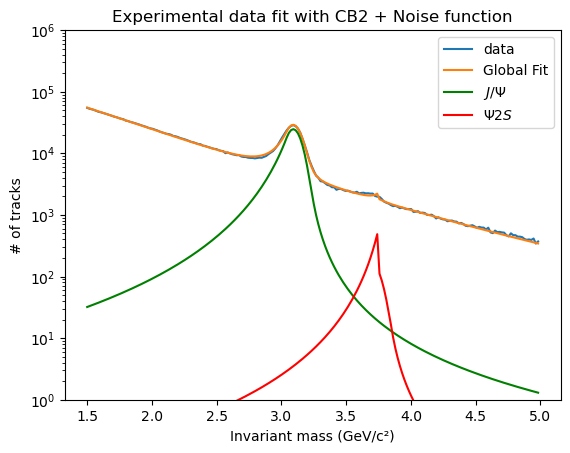

CPU times: user 1.71 s, sys: 54.8 ms, total: 1.77 s
Wall time: 2.16 s


In [42]:
%%time
#vhQualInvMassEvSel.plot(label="experimental data - events selected")
plt.plot(x_data,y_data, label="data")
plt.plot(x_data,y_data_fitCB2wNoise, label="Global Fit")
plt.plot(x_data,y_CB2_fit,'g', label="$J/\Psi$")
plt.plot(x_data,y_CB2_fit_psi,'r', label = "$\Psi 2S$")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.xlabel("Invariant mass (GeV/c²)")
plt.legend()
plt.title('Experimental data fit with CB2 + Noise function')
plt.ylim(1,1000000)
plt.show()

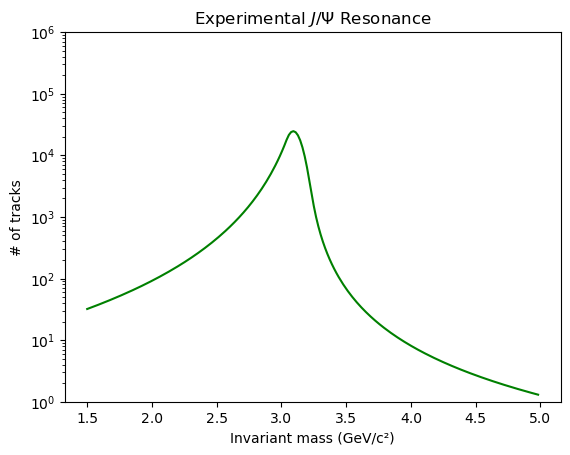

CPU times: user 1.54 s, sys: 26.5 ms, total: 1.57 s
Wall time: 1.89 s


In [29]:
%%time
#vhQualInvMassEvSel.plot(label="experimental data - events selected")
plt.plot(x_data,y_CB2_fit,'g')
plt.yscale("log")
plt.ylabel("# of tracks")
plt.xlabel("Invariant mass (GeV/c²)")
#plt.legend()
plt.title('Experimental $J/\Psi$ Resonance')
plt.ylim(1,1000000)
plt.show()

In [24]:
width=200
y_data_finale=[]
for i in x_data:
    y_data_finale.append(CrystalBall2_2(i, mu_fitCB2wNoise, sigma_fit,-0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise))

I = quad(CrystalBall2_2,1,5,
        args=(mu_fitCB2wNoise, sigma_fit,-0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise))
I = I[0] /0.175
print('Valeur de l intégrale en utilisant la fonction quad de scipy',I)

Valeur de l intégrale en utilisant la fonction quad de scipy 29839.000700236433


In [25]:
var_alpha,var_alpha1,var_n,var_n1 = 3.82025732e-04,1.74935625e-02,2.11990082e-01,1.42526094e-01
sigma_alpha = np.sqrt(var_alpha)
sigma_alpha1 = np.sqrt(var_alpha1)
sigma_n = np.sqrt(var_n)
sigma_n1 = np.sqrt(var_n1)
# définir le point où l'on veut calculer la dérivée partielle
point = [mu_fitCB2wNoise, sigma_fit,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise]

# définir la précision pour les calculs numériques
eps = 1e-10

# calculer la dérivée partielle par rapport à mu
d_mu = (CrystalBall2(x_data,point[0] + eps, point[1], point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_mu = sigma_mu * d_mu

# calculer la dérivée partielle par rapport à sigma
d_sigma = (CrystalBall2(x_data,point[0], point[1] + eps, point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_sigma = sigma_sigma*d_sigma

# calculer la dérivée partielle par rapport à alpha
d_N = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6]+eps) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_N = np.abs(sigma_N*d_N)

# liste des listes des dérivées
#d_list=[d_mu, d_sigma, d_alpha, d_alpha1, d_n, d_n1]
d_list_stat=[d_mu, d_sigma, d_N]

pas=x_data[1]-x_data[0]
integrale_list1 = []
for i in range(0,len(d_list_stat)):
    a=0
    for j in d_list_stat[i]:
        a = a + j*pas
    integrale_list1.append(a/0.175)
print(integrale_list1)

uncertainty_stat_NJPsi = sum(integrale_list1)
print("Nombre J/Psi :", I)
print("Incertitude statistique sur le nombre de J/Psi :", uncertainty_stat_NJPsi)
print(uncertainty_stat_NJPsi/I)

[1.634514391063353, 282.0100596604056, 246.13467713453423]
Nombre J/Psi : 29839.000700236433
Incertitude statistique sur le nombre de J/Psi : 529.7792511860032
0.01775459092977619
